In [1]:
%load_ext autoreload
%autoreload all

import torch
import numpy as np

from gem import DFC2022Dataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

n_tiles = 2 
dir_path = '/GEM/data/MiniFrance/'
dataset = DFC2022Dataset(dir_path, n_tiles=n_tiles, img_size=1024)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, num_workers=6)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True, num_workers=6)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


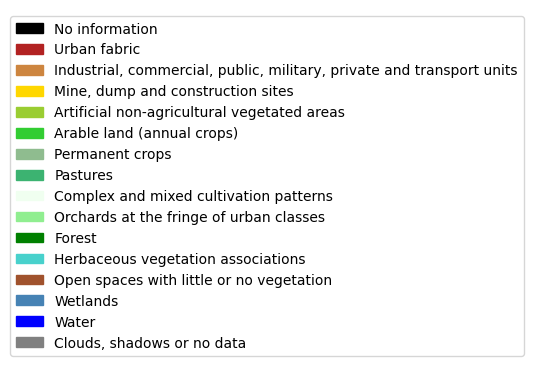

In [2]:
from typing import Any
import matplotlib.colors as mcolors

class_attributes: list[tuple[str, Any]] = [
    ("No information", mcolors.CSS4_COLORS['black']),
    ("Urban fabric", mcolors.CSS4_COLORS['firebrick']),
    ('Industrial, commercial, public, military, private and transport units', mcolors.CSS4_COLORS['peru']),
    ("Mine, dump and construction sites", mcolors.CSS4_COLORS['gold']),
    ("Artificial non-agricultural vegetated areas", mcolors.CSS4_COLORS['yellowgreen']),
    ("Arable land (annual crops)", mcolors.CSS4_COLORS['limegreen']),
    ("Permanent crops", mcolors.CSS4_COLORS['darkseagreen']),
    ("Pastures", mcolors.CSS4_COLORS['mediumseagreen']),
    ("Complex and mixed cultivation patterns", mcolors.CSS4_COLORS['honeydew']),
    ("Orchards at the fringe of urban classes", mcolors.CSS4_COLORS['lightgreen']),
    ("Forest", mcolors.CSS4_COLORS['green']),
    ("Herbaceous vegetation associations", mcolors.CSS4_COLORS['mediumturquoise']),
    ("Open spaces with little or no vegetation", mcolors.CSS4_COLORS['sienna']),
    ('Wetlands', mcolors.CSS4_COLORS['steelblue']),
    ("Water", mcolors.CSS4_COLORS['blue']),
    ("Clouds, shadows or no data", mcolors.CSS4_COLORS['gray']),
]

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

handles = [Patch(color=c, label=l) for l, c in class_attributes]
plt.legend(handles=handles)
plt.gca().set_axis_off()
plt.show()

In [3]:
class_percentages = dataset.calc_class_percentages()

In [4]:
sum_of_others = np.sum(class_percentages) - class_percentages
class_weights = np.divide(sum_of_others, class_percentages, out=np.zeros_like(sum_of_others), where=class_percentages!=0)
class_weights[0] = 0
class_weights_dict = {name: weight for weight, (name, _) in zip(class_weights, class_attributes)}
print(class_weights_dict)

{'No information': 0.0, 'Urban fabric': 10.394702411029012, 'Industrial, commercial, public, military, private and transport units': 17.191133886919648, 'Mine, dump and construction sites': 221.25559211417124, 'Artificial non-agricultural vegetated areas': 91.80799491529967, 'Arable land (annual crops)': 8.53215267075812, 'Permanent crops': 55.625437609244514, 'Pastures': 2.2555845706428816, 'Complex and mixed cultivation patterns': 0.0, 'Orchards at the fringe of urban classes': 0.0, 'Forest': 3.104646383806382, 'Herbaceous vegetation associations': 9.27984689954233, 'Open spaces with little or no vegetation': 41.70971996237496, 'Wetlands': 35.51076149777872, 'Water': 77.63680035709474, 'Clouds, shadows or no data': 0.0}


In [5]:
from gem.model import SegNet
from torch.nn.functional import one_hot
from torchvision.transforms import transforms
from torch.utils.tensorboard import SummaryWriter

tile_size = dataset.get_tile_size()
model = SegNet(features=32, out_channels=len(class_attributes))
model.to(device)

def get_inputs(data):
    normalize = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    if len(data['image'].shape) == 4:
        inputs = [normalize(image) for image in data['image']]
        inputs = torch.stack(inputs).float()
    else:
        inputs = normalize(data['image']).unsqueeze(0)

    return inputs

def get_labels(data):
    if len(data['mask'].shape) == 4:
        labels = [image for image in data['mask']]
        labels = torch.stack(labels)
    else:
        labels = data['mask']

    labels = one_hot(labels.long(), num_classes=len(class_attributes))
    labels = labels.squeeze(1).permute(0, 3, 1, 2).float()

    return labels


def train_one_epoch(optimizer, loss_fn, epoch_index: int, tb_writer: SummaryWriter):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_loader):
        inputs = get_inputs(data).to(device)
        labels = get_labels(data).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        log_step = 100
        if i % log_step == log_step - 1:
            last_loss = running_loss / log_step
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [6]:
from datetime import datetime

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/GEM/runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 120

for epoch in tqdm(range(EPOCHS)):
    model.train(True)
    avg_loss = train_one_epoch(optimizer, loss_fn, epoch_number, writer)

    running_vloss = 0.0
    model.eval()

    i = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs = get_inputs(data).to(device)
            labels = get_labels(data).to(device)

            outputs = model(inputs)
            vloss = loss_fn(outputs, labels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss, 'Validation' : avg_vloss},
                       epoch_number + 1)
    writer.flush()

    model_dir = '/GEM/models/'
    model_name = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_dir + model_name)

    epoch_number += 1

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:32<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from gem.model import SegNet
import numpy as np
import matplotlib.pyplot as plt


def plot_preds(batch, model):
    class_color_lut = np.array([mcolors.hex2color(color) for _, color in class_attributes]) * 255
    
    images = batch['image']
    labels = batch['mask']
    dems = batch['dem']
    inputs = get_inputs(batch).to(device)
    preds = model(inputs)

    for image, dem, pred, label in zip(images, dems, preds, labels):
        # Plot the image
        plt.subplot(1, 4, 1)
        plt.imshow(image.squeeze().cpu().int().numpy().transpose(1, 2, 0))
        plt.title('Image')
        plt.axis('off')

        # Plot the digital elevation model
        plt.subplot(1, 4, 2)
        plt.imshow(dem.squeeze().cpu().int().numpy())
        plt.title('DEM')
        plt.axis('off')

        # Plot the prediction
        plt.subplot(1, 4, 3)
        pred_img = pred.squeeze().argmax(dim=0).cpu().numpy()
        pred_img = class_color_lut[pred_img]
        plt.imshow(pred_img.astype(np.uint8))
        plt.title('Prediction')
        plt.axis('off')

        # Plot the label
        plt.subplot(1, 4, 4)
        label_img = label.squeeze().cpu().numpy()
        label_img = class_color_lut[label_img]
        plt.imshow(label_img.astype(np.uint8))
        plt.title('Label')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

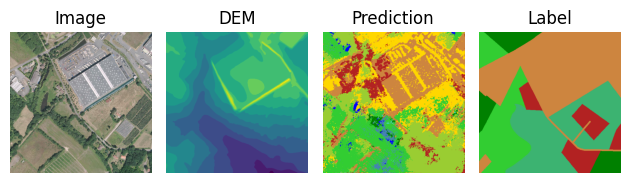

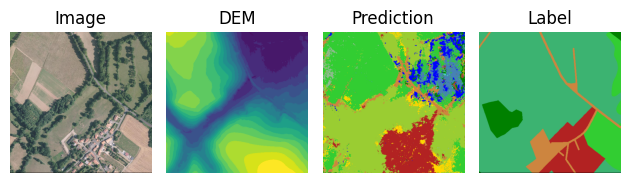

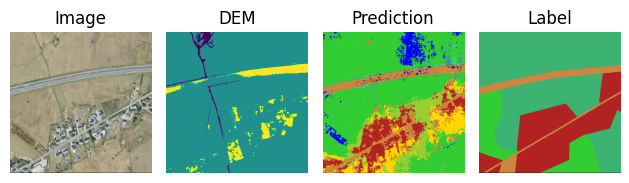

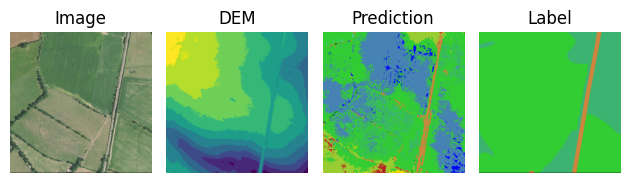

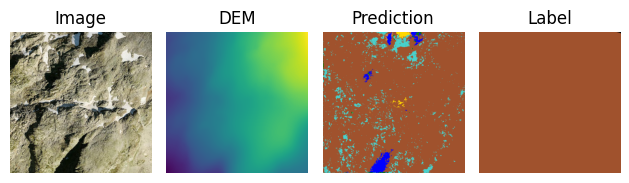

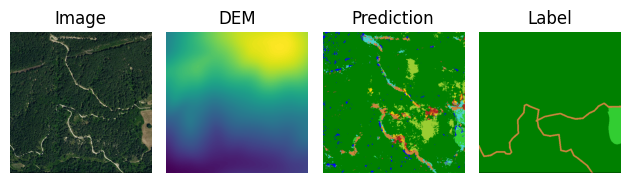

In [ ]:
trained_model = SegNet(features=32, out_channels=len(class_attributes))
trained_model.load_state_dict(torch.load('/GEM/models/model_20240422_222331_80'))
trained_model.to(device)
trained_model.eval()

batch = next(iter(train_loader))
plot_preds(batch, trained_model)

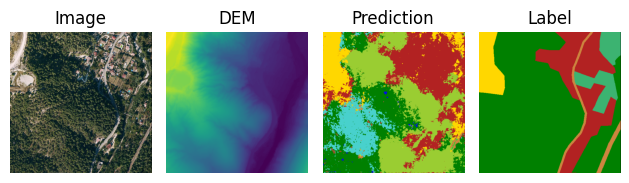

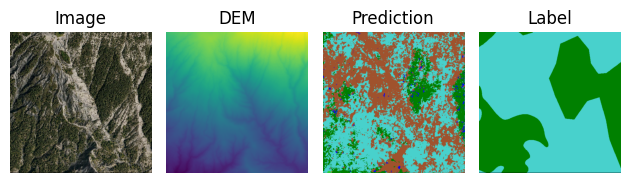

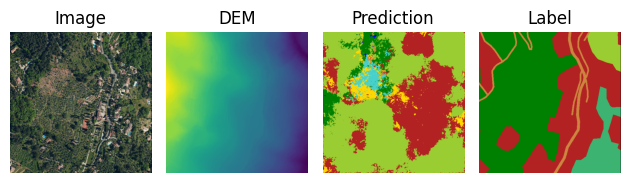

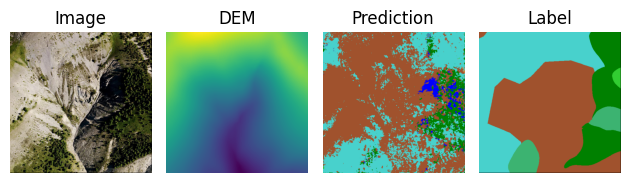

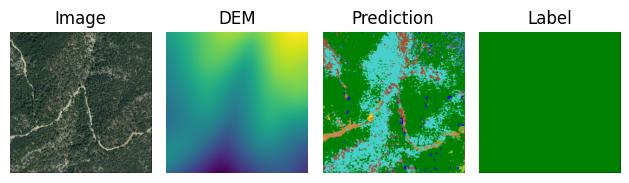

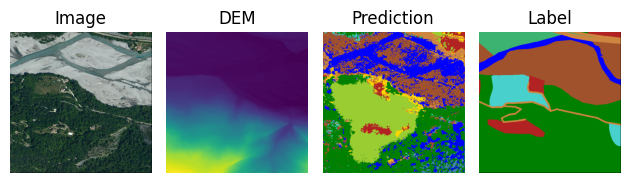

In [ ]:

data = next(iter(test_loader))
plot_preds(data, trained_model)